# Сборный проект-2. Анализ пользовательского поведения в мобильном приложении

# Описание проекта

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. Необходимо узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно? После этого необходимо исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Надо выяснить, какой шрифт лучше.

**Цель проекта**  

На основе данных использования мобильного приложения для продажи продуктов питания проанализировать воронку продаж, а также оценить результаты A/A/B-тестирования. 

**Ход исследования**  
1. Загрузка данных, общая информация.  
2. Предобработка данных.  
3. Изучение и проверка данных, в т.ч.:
 * Количество событий в логе.  
 * Количество пользователей в логе.  
 * Среднее количество событий на пользователя.
 * Анализ временного периода
 * Проверка пользователей групп
4. Изучение воронки событий, в т.ч.:  
 * Какие события есть в логах, как часто они встречаются.  
 * Сколько пользователей совершали каждое из этих событий. Доли пользователей, которые хоть раз совершали событие.  
 * Порядок событий.  
 * Какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)?  
 * На каком шаге теряете больше всего пользователей?  
 * Какая доля пользователей доходит от первого события до оплаты?  
5. Изучение результатов эксперимента, в т.ч.:  
 * Сколько пользователей в каждой экспериментальной группе?  
 * Проверка контрольных групп для А/А-эксперимента.  
 * Самое популярное событие. Число пользователей, совершивших это событие в каждой из контрольных групп. Долю пользователей, совершивших это событие. 
 * Анализ А/В, АА/В-тестов.  
 * Анализ уровня значимости при проверке статистических гипотез.  

**Описание данных**    
  
  
Каждая запись в логе — это действие пользователя, или событие.  

•	`EventName` — название события;  
•	`DeviceIDHash` — уникальный идентификатор пользователя;  
•	`EventTimestamp` — время события;  
•	`ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Загрузка данных

In [56]:
# библиотеки
import pandas as pd
import numpy as np
#from datetime import datetime, timedelta
import datetime as dt
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import math as mth
import plotly.express as px
from plotly import graph_objects as go

In [3]:
pd.set_option('display.float_format', '{:.2f}'.format)
colors = sns.color_palette('pastel')

In [4]:
# загружаем данные в дф
try:
    logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

except:
    logs = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')

In [5]:
# функция для просмотра данных о дф
def description(x):
    display('Первые строки таблицы:')
    display(x.head())
    print('*'*50)
    display('Общая информации о данных:')
    display(x.info())
    print('*'*50)
    display('Распределение численных показателей:')
    display(x.describe())
    print('*'*50)
    display('Проверка на дубликаты:')
    display(x.duplicated().sum())

In [6]:
description(logs)

'Первые строки таблицы:'

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


**************************************************


'Общая информации о данных:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

**************************************************


'Распределение численных показателей:'

,DeviceIDHash,EventTimestamp,ExpId
count,244126.00,244126.00,244126.00
mean,4627568124591259648.00,1564913915.84,247.02
std,2642424998963961856.00,177134.32,0.82
min,6888746892508752.00,1564029816.00,246.00
25%,2372212476992240640.00,1564756580.25,246.00
50%,4623191541214045184.00,1564919395.00,247.00
75%,6932517045703054336.00,1565074511.00,248.00
max,9222603179720523776.00,1565212517.00,248.00


**************************************************


'Проверка на дубликаты:'

413

**Вывод:** Дано 244126 строк, пропусков нет, дубликаты есть, названия столбцов следует привести к snake_case, скорректировать формат столбца с датой события.  

## Предобработка данных

* **корректировка названия столбцов**

In [7]:
# названия столбцов в нижний регистр
logs.columns = logs.columns.str.lower()
logs.columns

Index(['eventname', 'deviceidhash', 'eventtimestamp', 'expid'], dtype='object')

In [8]:
# названия столбцов к snake_case
logs.columns = ['event_name', 'user_id', 'event_timestamp', 'group']

* **добавление дополнительных столбцов**

In [9]:
# доп столбцы
logs['date_time'] = logs['event_timestamp'].apply(lambda x: dt.datetime.fromtimestamp(x))
logs['date'] = logs['date_time'].astype('datetime64[D]')
logs.head()

,event_name,user_id,event_timestamp,group,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


* **просмотр значений столбцов**

In [10]:
logs['group'].unique()

array([246, 248, 247])

In [11]:
logs['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

* **удаление дубликатов**

In [12]:
# удаляем дубликаты
logs = logs.drop_duplicates().reset_index(drop=True)

In [13]:
logs.duplicated().sum()

0

* **проверка пользователей**

In [49]:
# # проверка на пересечение пользователей по группам
# logs.groupby('user_id', as_index=False)['group'].nunique().query('group > 1')


Фиксируем количество логов и уникальных пользователей после проведения предобработки.

In [15]:
before_logs = logs.shape[0]
display(before_logs)
before_users = logs['user_id'].nunique()
display(before_users)

243713

7551

**Вывод:** Проведена предобработка данных: скорректированы названия столбцов, добавлены вспомогательные столбцы с датой и временем и датой совершения событий, удалены дубликаты. Итого даны три группы, на которые разделены пользователи, нет пользователей, состоящих более чем в одной группе. Событий в логах 5 видов.

## Изучение и проверка данных

### Количество событий в логе

In [16]:
logs['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

In [17]:
print('Всего событий %d, типов событий %d.' % (logs.shape[0], logs['event_name'].nunique()))

Всего событий 243713, типов событий 5.


В логах всего 243713 событий, в т.ч. 5 типов: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial.

### Количество пользователей в логе

In [18]:
logs['user_id'].nunique()

7551

### Среднее количество событий на пользователя

In [19]:
print('Среднее количество событий на пользователя: %d' % (logs.shape[0] / logs['user_id'].nunique()))

Среднее количество событий на пользователя: 32


In [34]:
logs.groupby('user_id').agg({'event_name': 'count'}).describe()

,event_name
count,7551.00
mean,32.28
std,65.15
min,1.00
25%,9.00
50%,20.00
75%,37.00
max,2307.00


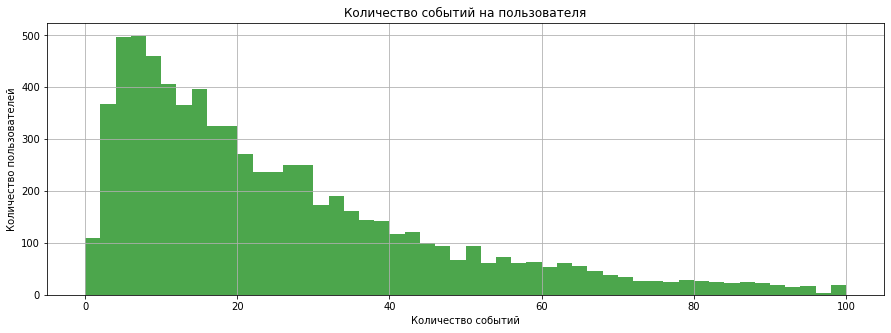

In [30]:
# диаграмма распределения кол-ва событий на пользователя
logs.groupby('user_id').agg({'event_name': 'count'}).hist(range=(0,100), bins=50, figsize=(15,5), alpha=0.7, color='green')
plt.title('Количество событий на пользователя')
#plt.locator_params(axis='x', nbins=20)
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей');

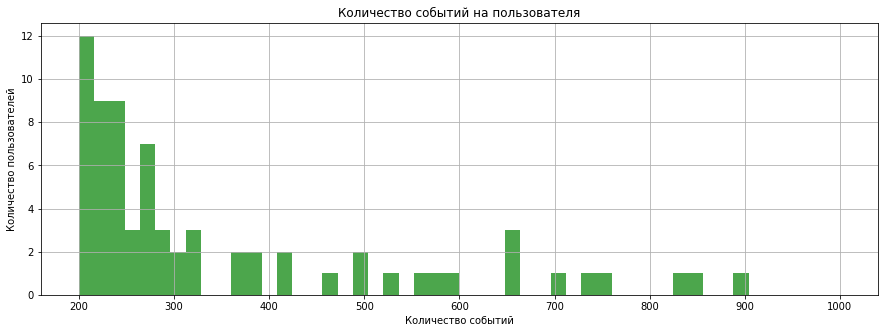

In [33]:
# диаграмма распределения кол-ва событий на пользователя
logs.groupby('user_id').agg({'event_name': 'count'}).hist(range=(200,1000), bins=50, figsize=(15,5), alpha=0.7, color='green')
plt.title('Количество событий на пользователя')
#plt.locator_params(axis='x', nbins=20)
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей');

Вывод: Среднее количество событий на пользователя - 32, медианное - 20. Однако есть некоторое число "гиперактивных" пользователей с количеством событий более 200.

### Временной период

In [19]:
#logs.sample()

In [35]:
print('Минимальная дата в логе:', logs['date'].dt.date.min())
print('Максимальная дата в логе:', logs['date'].dt.date.max())

Минимальная дата в логе: 2019-07-25
Максимальная дата в логе: 2019-08-07


Имеем события за период с 25.07.2019 по 07.08.2019 г. Построим гистограмму распределения событий по дате и времени суток.

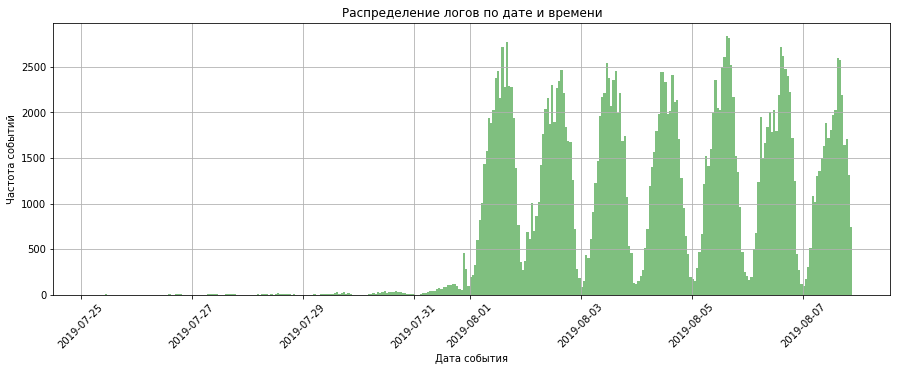

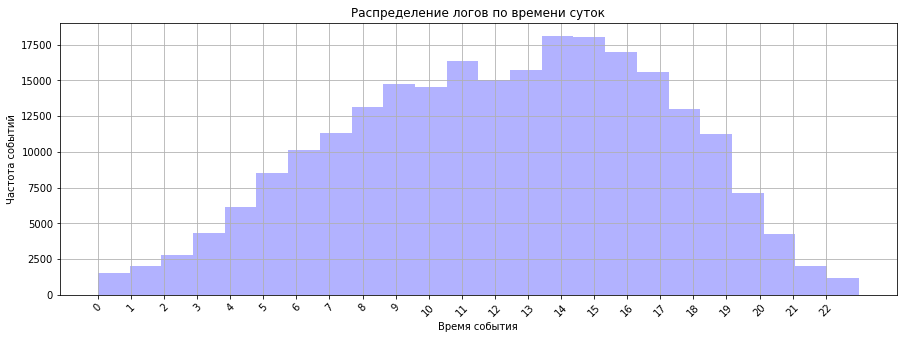

In [37]:
plt.title('Распределение логов по дате и времени')
logs['date_time'].hist(bins=14*24, figsize=(15,5), alpha=0.5, color='green')
plt.xticks(rotation=45)
plt.ylabel('Частота событий')
plt.xlabel('Дата события')
plt.show()

plt.title('Распределение логов по времени суток')
logs['date_time'].dt.hour.hist(bins=24, figsize=(15, 5), alpha=0.3, color='blue')
plt.xticks(rotation=45)
plt.xticks(range(0, 23))
plt.ylabel('Частота событий')
plt.xlabel('Время события')
plt.show();

In [38]:
logs.groupby('date', as_index=False).agg({'event_name':'count'})

,date,event_name
0,2019-07-25,9
1,2019-07-26,31
2,2019-07-27,55
3,2019-07-28,105
4,2019-07-29,184
5,2019-07-30,412
6,2019-07-31,2030
7,2019-08-01,36141
8,2019-08-02,35554
9,2019-08-03,33282


**Вывод:** И по гистограмме, и по сгруппированной таблице видно, что до 31.07.2019 включительно количество событий существенно меньше, чем в последующие даты. Из чего можно сделать вывод, что наиболее полные данные за период с 01.08.2019 по 07.08.2019г., т.е. за 7 дней. Активность пользователей наибольшая в дневные часы, наименьшая - в ночное, что вполне логично для проекта по продаже продуктов питания. 

In [39]:
# отсекаем данные за период до 01.08.19
logs = logs.query('date >= "2019-08-01"')
# новое количество событий и пользователей
after_logs = logs.shape[0]
after_users = logs['user_id'].nunique()

In [46]:
print(f'Изменение количества логов: {before_logs - after_logs}')
print(f'Относительное изменение количества логов: {round(100*(before_logs - after_logs)/before_logs,2)}%')

Изменение количества логов: 2826
Относительное изменение количества логов: 1.16%


In [45]:
print(f'Изменение количества пользователей: {before_users - after_users}')
print(f'Относительное изменение количества пользователей: {round((before_users - after_users)/before_users*100,2)}%')

Изменение количества пользователей: 17
Относительное изменение количества пользователей: 0.23%


* **Проверка распределения пользователей по группам**

In [47]:
# проверка на пересечение пользователей по группам
logs.groupby('user_id', as_index=False)['group'].nunique().query('group > 1')

,user_id,group


In [48]:
logs.groupby('group', as_index=False).agg({'user_id':'nunique'})

,group,user_id
0,246,2484
1,247,2513
2,248,2537


**Вывод:** Во всех группах примерно одинаковое количество пользователей, которые не пересекаются между собой.

## Воронки событий
- **Частота событий**  

Посмотрим, какие события есть в логах, как часто они встречаются. Для этого сгруппируем логи по типу события, подсчитаем частоту каждого события и количество уникальных пользователей, совершивших это событие.

In [50]:
# группируем данные по названию события
# считаем частоту каждого события
# и количество уникальных пользователей, совершивших это событие
events_grouped = (logs.
                  groupby('event_name').
                  agg({'event_name':'count','user_id': 'nunique'}).
                  rename(columns={'event_name':'total_events', 'user_id':'total_users'}).
                  reset_index().
                  sort_values(by='total_events', ascending=False))
events_grouped

,event_name,total_events,total_users
1,MainScreenAppear,117328,7419
2,OffersScreenAppear,46333,4593
0,CartScreenAppear,42303,3734
3,PaymentScreenSuccessful,33918,3539
4,Tutorial,1005,840


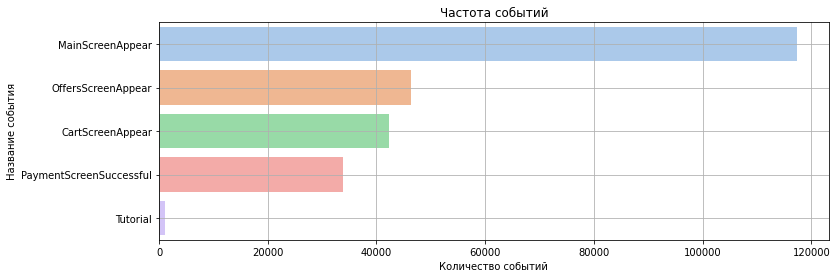

In [51]:
plt.figure(figsize=(12,4))
ax = sns.barplot(y=events_grouped['event_name'], x=events_grouped['total_events'], palette=colors)
ax.set_title('Частота событий')
ax.set_xlabel('Количество событий')
ax.set_ylabel('Название события')
plt.grid()
plt.show()

**Вывод:** Наиболее часто встречаемое событие - главная страница (`MainScreenAppear`), ее посетили 117889 раз. Далее идет каталог товаров/услуг (`OffersScreenAppear`) - 46531 раз. Страница с карточкой товара (`CartScreenAppear`) - 42343 раз. Страница с подтверждением оплаты (`PaymentScreenSuccessful`) - 33951 раз, страницу с инструкцией/обучающими материалам (`Tutorial`) посетили всего 1010 пользователей.

* **События по числу пользователей**  

Посчитаем, сколько пользователей совершали каждое из этих событий и долю пользователей, которые хоть раз совершали событие.

In [31]:
#after_users

In [52]:
# делим количество пользователей, совершивших конкретное событие, на общее число уникальных пользователей
events_grouped['one_event'] = round((events_grouped['total_users'] / logs['user_id'].nunique())*100.0, 2)
events_grouped = events_grouped.sort_values('total_users', ascending=False).reset_index(drop=True)
events_grouped

,event_name,total_events,total_users,one_event
0,MainScreenAppear,117328,7419,98.47
1,OffersScreenAppear,46333,4593,60.96
2,CartScreenAppear,42303,3734,49.56
3,PaymentScreenSuccessful,33918,3539,46.97
4,Tutorial,1005,840,11.15


**Вывод:** Главную страницу посетили 7419 пользователей (98.5% от общего числа пользователей). Каталог товаров - почти 61% от общего числа (4593 пользователя). Страницу с карточкой товара - почти 50% пользователей. Совершили оплату - почти 47%. Страницу с инструкцией/обучающими материалам - всего 11% от общего количества.  
  

* **Порядок событий**  

Небольшое количество пользователей, просмотревших страницу с инструкцией, говорит о том, что данная опция необязательная. Большая часть пользователей успевает закрыть эту страницу до того, как ее просмотр успеет попасть в логи. После этого пользователи попадают на стартовую страницу и общий порядок событий имеет следующий вид: 
 * Главная страница
 * Каталог товаров/услуг
 * Карточка товара
 * Страница с подтверждением оплаты.

Соответственно, пользователи, прошедшие Tutorial по умолчанию попадают на главную страницу (MainScreenAppear). Следовательно группа пользователей из Tutorial входит в группу пользователей, поучаствовавших в событии MainScreenAppear.  
Удалим из рассмотрения пользователей, входящих в Tutorial.



In [53]:
events_grouped = events_grouped.query('event_name != "Tutorial"')
events_grouped

,event_name,total_events,total_users,one_event
0,MainScreenAppear,117328,7419,98.47
1,OffersScreenAppear,46333,4593,60.96
2,CartScreenAppear,42303,3734,49.56
3,PaymentScreenSuccessful,33918,3539,46.97


* **Доля пользователей, перешедших на следующий шаг, потеря пользователей, доля пользователей, дошедших до оплаты**  

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). 

In [54]:
# считаем, какая доля пользователей переходит на следующий шаг воронки от числа на предыдущем шаге
events_grouped['funnel'] = 1
for i in range(1, 4):
    events_grouped.loc[i, 'funnel'] = events_grouped.loc[i, 'total_users'] /  (events_grouped.loc[i-1, 'total_users'])
events_grouped

/tmp/ipykernel_31/1133523050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_grouped['funnel'] = 1
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,event_name,total_events,total_users,one_event,funnel
0,MainScreenAppear,117328,7419,98.47,1.00
1,OffersScreenAppear,46333,4593,60.96,0.62
2,CartScreenAppear,42303,3734,49.56,0.81
3,PaymentScreenSuccessful,33918,3539,46.97,0.95


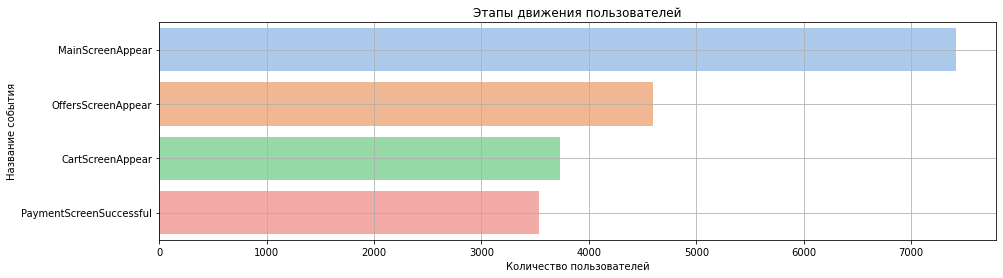

In [55]:
plt.figure(figsize=(15,4))
ax = sns.barplot(y=events_grouped['event_name'], x=events_grouped['total_users'], palette=colors)
ax.set_title('Этапы движения пользователей')
ax.set_xlabel('Количество пользователей')
ax.set_ylabel('Название события')
plt.grid()
plt.show()

In [76]:
# визуализируем воронку
fig = go.Figure(go.Funnel(y = events_grouped['event_name'],
                          x = events_grouped['total_users'],
                          opacity = 0.9,
                          textposition = 'inside',
                          marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"]},
                          textinfo = 'value + percent previous'))
fig.update_layout(title_text='Воронка событий')
fig.show()

**Вывод:** Как видно из расчетов и диаграммы, наибольшая потеря пользователей происходит на этапе перехода с главной страницы до страницы с каталогов товаров. Потери составляют почти 40%. Возможные причины: пользователь случайно зашел в приложение и сразу вышел, либо какая-то техническая проблема с переходом в каталог товаров в самом приложении, либо неудобный/нелогичный интерфейс приложения.  
На следующих этапах потери уже не такие ощутимые: примерно 19% (от предыдущего этапа) не доходят до карточек товаров и всего 5% не совершают оплату.  
Примерно 47% пользователей доходят от первого первого события до совершения оплаты.

# Результаты эксперимента

•	**Количество пользователей в каждой экспериментальной группе**


In [77]:
users_count = logs.groupby('group', as_index=False).agg({'user_id':'nunique'})
users_count.loc[[0,1]]
users_count = users_count.append(users_count.loc[[0, 1]].sum(), ignore_index=True)
users_count.iloc[3,0] = 'AA'
users_count

,group,user_id
0,246,2484
1,247,2513
2,248,2537
3,AA,4997


Дано: три группы: 246, 247, 248, где группы 246 и 247 - контрольные, 248 - экспериментальная. В каждой, соответственно, 2484, 2513, 2537 пользователей.

• **Проверка контрольных групп А/А**  

Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов.  

Критерии успешного A/A-теста:  
1. Количество пользователей в различных группах различается не более, чем на 1%;  
2. Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;  
3. Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
4. Попавший в одну из групп посетитель остаётся в этой группе до конца теста.   

Исходим из того, что пункт 2 выполняется. Пункт 4 проверен ранее, пользователи "не мигрируют" между группами. Остается проверить пункты 1 и 3.

In [78]:
# проверим количество пользователей
users_246 = logs[logs['group'] == 246]['user_id'].nunique()
users_247 = logs[logs['group'] == 247]['user_id'].nunique()
users_248 = logs[logs['group'] == 248]['user_id'].nunique()
print('Разница в количестве пользователей в контрольных группах: {:.2f}'.format((1 - users_246/users_247)*100))

Разница в количестве пользователей в контрольных группах: 1.15


Разница в количестве пользователей несущественная. Остается проверить группы на наличие статистически значимых отличий.  

Сформируем сводную таблицу с подсчетом количества пользователей для каждого события в каждой группе тестирования.

In [82]:
users_by_events = (logs[logs['event_name'] != "Tutorial"]
                   .pivot_table(index = 'event_name',
                                columns = 'group',
                                values = 'user_id',
                                aggfunc = 'nunique')
                   .sort_values(by=246, ascending=False)
                   .reset_index()
                  )
users_by_events.columns = ['event_name', '246','247','248']
# сразу добавляем столбец с показателями объединенной контрольной группы
users_by_events['aa'] = users_by_events['246'] + users_by_events['247']
# общее количество пользователей для каждого события
users_by_events['aab'] = users_by_events[['246','247','248']].sum(axis = 1)
# доля пользователей групп, совершивших событие
users_by_events['246_part'] = users_by_events['246'] / users_246
users_by_events['247_part'] = users_by_events['247'] / users_247
users_by_events['248_part'] = users_by_events['248'] / users_248
users_by_events['aa_part'] = users_by_events['aa'] / (users_246 + users_247)

users_by_events

,event_name,246,247,248,aa,aab,246_part,247_part,248_part,aa_part
0,MainScreenAppear,2450,2476,2493,4926,7419,0.99,0.99,0.98,0.99
1,OffersScreenAppear,1542,1520,1531,3062,4593,0.62,0.60,0.60,0.61
2,CartScreenAppear,1266,1238,1230,2504,3734,0.51,0.49,0.48,0.50
3,PaymentScreenSuccessful,1200,1158,1181,2358,3539,0.48,0.46,0.47,0.47


Напишем функцию для проверки наличия статистической разницы между группами.

In [83]:
# функция проверки наличия стат разницы 
def check_stats(df1, df2, event, alpha):
    # список из количества пользователей в каждой из сравниваемых групп
    users_count = np.array([df1['user_id'].nunique(),
                            df2['user_id'].nunique()])
    # список из количества пользователей, совершивших событие event в каждой из групп
    success_users = np.array([df1[df1['event_name'] == event]['user_id'].nunique(),
                              df2[df2['event_name'] == event]['user_id'].nunique()]) 
    # пропорция успехов в каждой из групп:
    p1 = success_users[0] / users_count[0]
    p2 = success_users[1] / users_count[1]
    # пропорция успехов в комбинированной группе
    p_combined = (success_users[0]+success_users[1]) / (users_count[0]+users_count[1])
    # разница пропорций в датасетах
    difference = p1-p2
    # расчет статистики в ст. отклонениях ст. норм. распределения
    z_value = difference / (p_combined * (1 - p_combined) * (1/users_count[0] + 1/users_count[1])) ** 0.5
    # задаем N(0,1)
    distr = st.norm(0,1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    # вывод результатов: название событий и значение p_value
    print('Событие:', event)
    print('p-значение:', p_value)
    
    # сравниваем p_value с уровнем стат значимости 
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')  

In [84]:
def check_stats2(sucsess_1, trials_1, sucsess_2, trials_2, alpha):
    # пропорция успехов в первой группе
    p1 = sucsess_1 / trials_1
    # пропорция успехов во второй группе:
    p2 = sucsess_2 / trials_2
    # пропорция успехов в комбинированной выборке
    p_combined = ((sucsess_1 + sucsess_2) / (trials_1 + trials_2))
    # разница пропорций
    difference = p1 - p2
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = (difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_1 + 1/trials_2)))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        
    print()

In [90]:
# проверка для 246/247 для MainScreenAppear
check_stats2(users_by_events.iloc[0,1], users_246, users_by_events.iloc[0,2], users_247, 0.05)

p-значение:  0.7570597232046099
     Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Формулируем нулевую и альтернативную гипотезы:**   
**H0:** доли уникальных пользователей, совершивших событие (побывавших на этапе воронки) в каждой из контрольных групп, одинаковы.  
**H1:** доли уникальных пользователей, совершивших событие (побывавших на этапе воронки) в каждой из контрольных групп, различаются.  

**Проверим, есть ли статистически значимая разница между контрольными группами 246 и 247:**

In [91]:
alpha = 0.05

In [92]:
for event in users_by_events['event_name'].unique():
    check_stats(logs[logs['group'] == 246], logs[logs['group'] == 247], event, alpha)
    print('-'*50)

Событие: MainScreenAppear
p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------
Событие: OffersScreenAppear
p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------
Событие: CartScreenAppear
p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------
Событие: PaymentScreenSuccessful
p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------


**Вывод:** Тест А/А проведен корректно, статистически значимых различий между двумя контрольными А-группами не обнаружено, все критерии корректности проведения теста соблюдены.

•	**Самое популярное событие**  

Определим самое популярное событие:

In [93]:
# в разрезе всех пользователей в целом
logs['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

In [94]:
# и для пользователей каждой из групп
users_by_events

,event_name,246,247,248,aa,aab,246_part,247_part,248_part,aa_part
0,MainScreenAppear,2450,2476,2493,4926,7419,0.99,0.99,0.98,0.99
1,OffersScreenAppear,1542,1520,1531,3062,4593,0.62,0.60,0.60,0.61
2,CartScreenAppear,1266,1238,1230,2504,3734,0.51,0.49,0.48,0.50
3,PaymentScreenSuccessful,1200,1158,1181,2358,3539,0.48,0.46,0.47,0.47


**Самое популярное событие** - просмотр главной страницы (`MainScreenAppear`). В первой контрольной группе просмотр главной страницы совершили 2450 уникальных пользователей, во второй контрольной группе - 2476, в экспериментальной 248 группе - 2493 пользователя, что составляет 99, 99, 98% от общего числа пользователей каждой из групп соответственно. 

* **Проведение A/B-теста**  
  
Проведем еще три теста: А1/В, А2/В и АА/В.  

* **A1/B-тест**  

Формулируем нулевую и альтернативную гипотезы:  
 **H0:** доли уникальных пользователей, совершивших событие (побывавших на этапе воронки) в 246 и 248 группах, одинаковы.  
 **H1:** доли уникальных пользователей, совершивших событие (побывавших на этапе воронки) в 246 и 248 группах, различаются.  

**Проверим, есть ли статистически значимая разница между первой контрольной и экспериментальной группами:**

In [95]:
# задаем уровень стат значимости
alpha = 0.05

In [96]:
for event in users_by_events['event_name'].unique():
    check_stats(logs[logs['group'] == 246], logs[logs['group'] == 248], event, alpha)
    print('-'*50)

Событие: MainScreenAppear
p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------
Событие: OffersScreenAppear
p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------
Событие: CartScreenAppear
p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------
Событие: PaymentScreenSuccessful
p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------


При заданном уровне значимости нет оснований считать группы 246 и 248 статистически разными.

* **A2/B-тест**  

Формулируем нулевую и альтернативную гипотезы:  
 **H0:** доли уникальных пользователей, совершивших событие (побывавших на этапе воронки) в 247 и 248 группах, одинаковы.  
 **H1:** доли уникальных пользователей, совершивших событие (побывавших на этапе воронки) в 247 и 248 группах, различаются.  

**Проверим, есть ли статистически значимая разница между второй контрольной и экспериментальной группами:**

In [97]:
for event in users_by_events['event_name'].unique():
    check_stats(logs[logs['group'] == 247], logs[logs['group'] == 248], event, alpha)
    print('-'*50)

Событие: MainScreenAppear
p-значение: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------
Событие: OffersScreenAppear
p-значение: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------
Событие: CartScreenAppear
p-значение: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------
Событие: PaymentScreenSuccessful
p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------


Аналогичный результат, при заданном уровне значимости нет оснований считать группы 247 и 248 статистически разными.

* **AA/B-тест**  

Формулируем нулевую и альтернативную гипотезы:  
 **H0:** доли уникальных пользователей, совершивших событие (побывавших на этапе воронки) в объединенной контрольной и экспериментальной группах, одинаковы.  
 **H1:** доли уникальных пользователей, совершивших событие (побывавших на этапе воронки) в объединенной контрольной и экспериментальной группах, различаются.  

**Проверим, есть ли статистически значимая разница между объединенной контрольной и экспериментальной группами:**

In [98]:
for event in users_by_events['event_name'].unique():
    check_stats(logs[logs['group'] != 248], logs[logs['group'] == 248], event, alpha)
    print('-'*50)

Событие: MainScreenAppear
p-значение: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------
Событие: OffersScreenAppear
p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------
Событие: CartScreenAppear
p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------
Событие: PaymentScreenSuccessful
p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------


При заданном уровне значимости нет оснований считать объединенную контрольную и экспериментальную группы статистически разными.

* **Уровень статистической значимости**  

При проверке статистических гипотез был выбран уровень значимости равный 0.05. При проведении множественного теста, т.е. нескольких сравнений, проводимых на одних и тех же данных, с каждой новой проверкой гипотезы возрастает вероятность ошибки первого рода, т.е. при отсутствии различий между сравниваемыми группами, тест покажет p-value меньше уровня значимости. И Нулевая гипотеза будет отвергнута.  


Всего было проведено 16 проверок гипотез (попарные сравнения для 4 групп (А/А, А1/В, А2/В, АА/В) для 4 событий). При проведении 16 проверок вероятность допустимого ложноположительного результата хотя бы в одном тесте увеличивается до 1 - (1 - 0.05)**16 (56/100).

Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез, применяют разные методы корректировки уровня значимости, в т.ч. метод Бонферрони, согласно которому уровень значимости для каждой гипотезы делят на число гипотез.

In [99]:
bonferroni = alpha/16
bonferroni

0.003125

Однако при этом мы видим, что во всех проводимых ранее тестах полученные значения p-value всегда больше скорректированного уровня значимости (0.003125), поэтому нет смысла повторно проводить тесты, результат останется тот же, а именно: нет причин отвергать нулевую гипотезу о равенстве долей всех рассматриваемых выборок.  

**Вывод: По результатам всех проверок видно, что статистически значимых различий между группами 246, 247 и 248 нет. Предварительно можно сделать вывод, что замена шрифта никак не повлияла на поведение пользователей.**


## Общий вывод  



В ходе проделанной работы было выполнено:

1. Изучены исходные данные.
2. Проведена предобработка данных, в т.ч. корректировка типов данных, добавление доп. столбцов, удаление дубликатов.
3. Проведен анализ имеющихся данных, в ходе которого сделаны следующие выводы:
 * В логах всего более 24 тыс. событий, типов событий 5 (MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial) за период с 25.07.2019 по 07.08.2019 г. Однако наиболее полные данные за период с 01.08.2019 по 07.08.2019г., т.е. за 7 дней. Активность пользователей наибольшая в дневные часы, наименьшая - в ночное, что вполне логично для проекта по продаже продуктов питания.
 * Наиболее часто встречаемое событие - главная страница (MainScreenAppear), ее посетили 117889 раз. Общий порядок событий следующий: Главная страница - Каталог товаров/услуг - Карточка товара - Страница с подтверждением оплаты.
 * Наибольшая потеря пользователей происходит на этапе перехода с главной страницы до страницы с каталогов товаров. Потери составляют почти 40%. На следующих этапах потери уже не такие ощутимые. Примерно 47% пользователей доходят от первого первого события до совершения оплаты.
4. Были проанализированы результаты A/A/B-теста введения новых шрифтов, в т.ч.:
 * Проверена корректность проведения А/А-теста: статистически значимых различий между двумя контрольными А-группами не обнаружено, все критерии корректности проведения теста соблюдены.
 * Проверены гипотезы об отсутствии различий в долях уникальных пользователей, совершивших событие в каждой из групп. По результатам всех проверок выявлено, что статистически значимых различий между группами 246, 247 и 248 нет. 
 * Корректировка уровня значимости с помощью метода Бонферрони не изменила результатов тестирования. 
**Проведенный анализ не выявил различий в поведении пользавателей от замены шрифта. Также рекомендуется обратить внимание на ощутимую потерю пользователей при перехоже от главного экрана к странице с каталогом товаров (стоит проверить, нет ли каких-то технических проблема с переходом в каталог товаров в самом приложении, понятен ли интерфейс приложения на данном этапе.**